# NEW PROJECT FROM SCRATCH

### New Classification

In [ ]:
# -*- coding: utf-8 -*-
"""
Research_Paper_recommendation_and_subject_area_prediction_using_sentence_transformer.ipynb

This script has been refactored to remove redundant preprocessing steps.
The data pipeline is now:
1.  Load and deduplicate data.
2.  Perform a single, robust train-validation-test split.
3.  Clean and filter labels based *only* on the training set to prevent data leakage.
4.  Create label binarizer (StringLookup) and text vectorizer from the training set.
5.  Prepare tf.data.Dataset objects for training.
"""

# ==============================================================================
# 1. Loading Tools and Initial Setup
# ==============================================================================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from ast import literal_eval
import re
import matplotlib.pyplot as plt

arxiv_data = pd.read_csv("arxiv_data.csv")

# Perform initial deduplication based on titles to ensure data integrity early on.
print(f"Original number of rows: {len(arxiv_data)}")
arxiv_data = arxiv_data.drop_duplicates(subset=['titles'])
print(f"Number of rows after deduplication: {len(arxiv_data)}")
print("-" * 30)

# ==============================================================================
# 2. Data Cleaning, Splitting, and Curation (Consolidated)
# ==============================================================================

# --- Step 2.1: Define and apply the cleaning function for the 'terms' column ---
print("🧹 Cleaning and normalizing the 'terms' column...")
def clean_and_normalize_terms(term_string):
    """Handles both list-formatted and string-formatted terms."""
    try:
        # Safely evaluate strings like "['cs.CV', 'cs.LG']"
        terms = literal_eval(term_string)
    except (ValueError, SyntaxError):
        # Handle plain strings like "'cs.CV'" or "'I.2.6; I.5.4'"
        terms = term_string

    if isinstance(terms, list):
        return [str(term).strip() for term in terms]
    elif isinstance(terms, str):
        # Splits a single string with multiple labels (comma or semicolon) into a list
        return [term.strip() for term in re.split('[,;]', terms)]
    else:
        # Return an empty list for any other unexpected data type
        return []

arxiv_data['terms'] = arxiv_data['terms'].apply(clean_and_normalize_terms)

# --- Step 2.2: Split the Data FIRST to prevent data leakage ---
print("\nSpliting data into training, validation, and test sets (80/10/10)...")
train_df, test_val_df = train_test_split(arxiv_data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

print(f"Split sizes: Train({len(train_df)}), Validation({len(val_df)}), Test({len(test_df)})")
print("-" * 30)


# --- Step 2.3: Determine which classes to keep based ONLY on the training data ---
print("\nAnalyzing training data to determine which classes to keep...")
class_distribution = train_df['terms'].explode().value_counts()

# Set a threshold for the minimum number of samples a class must have in the training set
min_samples = 50
classes_to_keep = class_distribution[class_distribution >= min_samples].index.tolist()

print(f"Original number of unique classes in training data: {len(class_distribution)}")
print(f"Number of classes with >= {min_samples} samples: {len(classes_to_keep)}")
print("-" * 30)


# --- Step 2.4: Filter all datasets to use only the selected classes ---
print("\nFiltering all sets to only include common, frequent classes...")
def filter_terms_list(terms_list):
    """Removes any term not in our 'classes_to_keep' list."""
    return [term for term in terms_list if term in classes_to_keep]

train_df['terms'] = train_df['terms'].apply(filter_terms_list)
val_df['terms'] = val_df['terms'].apply(filter_terms_list)
test_df['terms'] = test_df['terms'].apply(filter_terms_list)


# --- Step 2.5: Remove rows that have no labels left after filtering ---
print("\nRemoving rows that have no valid labels remaining...")
train_df = train_df[train_df['terms'].str.len() > 0]
val_df = val_df[val_df['terms'].str.len() > 0]
test_df = test_df[test_df['terms'].str.len() > 0]

print("\nData shapes after all filtering:")
print(f"Training set:   {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set:       {len(test_df)} rows")
print("\n✅ Curation complete.")
print("-" * 30)


# ==============================================================================
# 3. Label Binarization and Vocabulary Creation
# ==============================================================================
print("\nBuilding label vocabulary from the training data...")
# Use a RaggedTensor to handle lists of varying lengths.
terms = tf.ragged.constant(train_df['terms'].values)

# Create and adapt the StringLookup layer ONLY on the training data.
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

print(f"Vocabulary size: {len(vocab)}")
print("Sample of vocabulary:", vocab[:10])
print("-" * 30)


# ==============================================================================
# 4. Creating tf.data.Dataset for Model Input
# ==============================================================================
print("\nCreating TensorFlow datasets...")
batch_size = 128
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    """Converts a pandas DataFrame into a tf.data.Dataset."""
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    return dataset.batch(batch_size)

train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

print("Datasets created successfully.")
print("-" * 30)


# ==============================================================================
# 5. Text Vectorization
# ==============================================================================
print("\nSetting up the text vectorization layer...")

# First, calculate the vocabulary size from the training summaries.
# This is a more memory-efficient way than creating a giant set in memory.
def get_vocabulary_size(text_series):
    # Create a temporary TextVectorization layer to count unique tokens
    temp_vectorizer = layers.TextVectorization(max_tokens=None, split='whitespace')
    temp_vectorizer.adapt(text_series)
    return len(temp_vectorizer.get_vocabulary())

vocabulary_size = get_vocabulary_size(train_df['summaries'])
print(f"Calculated text vocabulary size: {vocabulary_size}")


# Initialize the TextVectorization layer for the model.
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size,
    ngrams=2,
    output_mode="tf_idf"
)

# Adapt the vectorizer ONLY on the text from the training dataset.
print("Adapting text vectorizer...")
train_text_only = train_dataset.map(lambda text, label: text)
text_vectorizer.adapt(train_text_only)

# Map the vectorization to all datasets
print("Applying vectorization to all datasets...")
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

print("\n✅ Preprocessing and data pipeline setup complete. Ready for model training.")
print("-" * 30)


# ==============================================================================
# 6. Model Training (Original script continues from here)
# ==============================================================================

# NOTE: The rest of your script (model definition, compilation, callbacks, and fitting)
# would follow here, starting with the `model1 = keras.Sequential([...])` block.

Original number of rows: 51774
Number of rows after deduplication: 38972
------------------------------
🧹 Cleaning and normalizing the 'terms' column...

Spliting data into training, validation, and test sets (80/10/10)...
Split sizes: Train(31177), Validation(3897), Test(3898)
------------------------------

Analyzing training data to determine which classes to keep...
Original number of unique classes in training data: 921
Number of classes with >= 50 samples: 46
------------------------------

Filtering all sets to only include common, frequent classes...

Removing rows that have no valid labels remaining...

Data shapes after all filtering:
Training set:   31177 rows
Validation set: 3897 rows
Test set:       3898 rows

✅ Curation complete.
------------------------------

Building label vocabulary from the training data...
Vocabulary size: 47
Sample of vocabulary: ['[UNK]', np.str_('cs.CV'), np.str_('cs.LG'), np.str_('stat.ML'), np.str_('cs.AI'), np.str_('eess.IV'), np.str_('cs.RO')

In [ ]:
# ==============================================================================
# 6. Model Training (Add this section after the preprocessing)
# ==============================================================================
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive

# Mount Google Drive to save the model checkpoints
drive.mount('/content/drive')

# --- Define the Model Architecture ---
model1 = tf.keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

# --- Compile the Model ---
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

# --- Define Callbacks ---
# Stop training early if validation loss doesn't improve
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Define the path in your Google Drive to save the best model
model_save_path = '/content/drive/My Drive/Colab Notebooks/my_best_model.keras'

# Save the model periodically when validation loss improves
checkpoint_callback = ModelCheckpoint(
    filepath=model_save_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- Start Training ---
print("\n🚀 Starting model training...")
history = model1.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopping, checkpoint_callback]
)
print("✅ Training complete.")

Mounted at /content/drive

🚀 Starting model training...
Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9430 - loss: 0.1756
Epoch 1: val_loss improved from inf to 0.06637, saving model to /content/drive/My Drive/Colab Notebooks/my_best_model.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - binary_accuracy: 0.9432 - loss: 0.1753 - val_binary_accuracy: 0.9801 - val_loss: 0.0664
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9808 - loss: 0.0651
Epoch 2: val_loss improved from 0.06637 to 0.06610, saving model to /content/drive/My Drive/Colab Notebooks/my_best_model.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - binary_accuracy: 0.9808 - loss: 0.0651 - val_binary_accuracy: 0.9802 - val_loss: 0.0661
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9841 - loss: 0.0507
Epoch 3: val_loss did not improve from 0.06610
244/244 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - binary_accuracy: 0.9841 - loss: 0.0507 - val_binary_accuracy:

In [22]:
import numpy as np
from tensorflow import keras

# ==============================================================================
# 1. Load All Necessary Components
# ==============================================================================
# Load the main trained model from your Google Drive
model_path = '/content/drive/My Drive/Colab Notebooks/my_best_model.keras'
loaded_model = keras.models.load_model(model_path)

# You must also have the text vectorizer and vocab that were used for training.
# Let's assume they are already loaded in your session. If not, you'd load them like this:
#
# loaded_vectorizer_model = keras.models.load_model("vectorizer.h5")
# text_vectorizer = loaded_vectorizer_model.layers[0]
#
# import pickle
# with open("vocab.pkl", "rb") as f:
#     vocab = pickle.load(f)

print("✅ Model and components ready for prediction.")

# ==============================================================================
# 2. Define the Prediction Function
# ==============================================================================
def predict_subject_area(text, model, vectorizer, label_vocab):
    """
    Takes a string of text and predicts its subject area(s).
    """
    # The vectorizer expects a list of strings
    preprocessed_text = vectorizer([text])

    # Get the model's raw predictions (probabilities)
    predictions = model.predict(preprocessed_text)

    # Round the probabilities to 0 or 1 to get the final decision
    binary_predictions = np.round(predictions).astype(int)[0]

    # Find the indices where the prediction is 1
    hot_indices = np.argwhere(binary_predictions == 1.0).flatten()

    # Use the indices to look up the subject names from the vocabulary
    predicted_labels = np.take(label_vocab, hot_indices)

    return predicted_labels

# ==============================================================================
# 3. Use the Function to Predict
# ==============================================================================
# Example: New paper abstract
new_abstract = "We introduce a novel deep learning architecture for natural language understanding. Our model, based on transformers, achieves state-of-the-art results on several benchmarks by using a unique attention mechanism. This work has significant implications for machine translation and text summarization."

# Get the prediction
predicted_subjects = predict_subject_area(new_abstract, loaded_model, text_vectorizer, vocab)

print(f"\nText to classify:\n'{new_abstract}'")
print(f"\nPredicted Subject(s): {list(predicted_subjects)}")

✅ Model and components ready for prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step

Text to classify:
'We introduce a novel deep learning architecture for natural language understanding. Our model, based on transformers, achieves state-of-the-art results on several benchmarks by using a unique attention mechanism. This work has significant implications for machine translation and text summarization.'

Predicted Subject(s): [np.str_('cs.LG'), np.str_('stat.ML'), np.str_('cs.CL')]


In [19]:
# Add this RIGHT AFTER your training completes (after the model1.fit() line)
# This goes after: print("✅ Training complete.")

import pickle
import os

print("\n💾 Saving all components for local deployment...")

# Create directory in Google Drive for saving everything
save_dir = '/content/drive/My Drive/Colab Notebooks/local_deployment'
os.makedirs(save_dir, exist_ok=True)

# 1. Save the complete vectorizer with TF-IDF weights (MOST IMPORTANT)
print("Saving complete vectorizer...")
vectorizer_model = tf.keras.Sequential([text_vectorizer])
vectorizer_model.save(f'{save_dir}/complete_vectorizer.keras')
print("✅ Complete vectorizer saved")

# 2. Save the label vocabulary (subject names)
print("Saving label vocabulary...")
label_vocab = lookup.get_vocabulary()  # This is your 'vocab' from prediction
with open(f'{save_dir}/label_vocabulary.pkl', 'wb') as f:
    pickle.dump(label_vocab, f)
print(f"✅ Label vocabulary saved ({len(label_vocab)} subjects)")

# 3. Copy the main model to the same folder for organization
print("Copying main model...")
import shutil
shutil.copy(model_save_path, f'{save_dir}/model.keras')
print("✅ Main model copied")

# 4. Save configuration for verification
config = {
    'model_path': 'model.keras',
    'vectorizer_path': 'complete_vectorizer.keras',
    'label_vocab_path': 'label_vocabulary.pkl',
    'num_classes': len(label_vocab),
    'text_vocab_size': text_vectorizer.vocabulary_size(),
    'training_complete': True
}

with open(f'{save_dir}/config.json', 'w') as f:
    import json
    json.dump(config, f, indent=2)

print("\n📁 All files saved to Google Drive:")
print(f"📂 {save_dir}/")
print("   ├── model.keras (main classification model)")
print("   ├── complete_vectorizer.keras (text vectorizer with TF-IDF)")
print("   ├── label_vocabulary.pkl (subject names)")
print("   └── config.json (configuration)")

print("\n🚀 Ready for local deployment!")
print("Download the 'local_deployment' folder to your local 'models/' directory.")

# Test that everything works before finishing
print("\n🧪 Testing the saved components...")
try:
    # Test loading
    test_model = keras.models.load_model(f'{save_dir}/model.keras')
    test_vectorizer_model = keras.models.load_model(f'{save_dir}/complete_vectorizer.keras')
    test_vectorizer = test_vectorizer_model.layers[0]

    with open(f'{save_dir}/label_vocabulary.pkl', 'rb') as f:
        test_vocab = pickle.load(f)

    # Test prediction
    test_text = "machine learning algorithms"
    test_processed = test_vectorizer([test_text])
    test_pred = test_model.predict(test_processed, verbose=0)

    print("✅ All components test successfully!")
    print("✅ Ready for local deployment!")

except Exception as e:
    print(f"❌ Test failed: {e}")
    print("Check the saved files before downloading.")


💾 Saving all components for local deployment...
Saving complete vectorizer...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


✅ Complete vectorizer saved
Saving label vocabulary...
✅ Label vocabulary saved (47 subjects)
Copying main model...
✅ Main model copied

📁 All files saved to Google Drive:
📂 /content/drive/My Drive/Colab Notebooks/local_deployment/
   ├── model.keras (main classification model)
   ├── complete_vectorizer.keras (text vectorizer with TF-IDF)
   ├── label_vocabulary.pkl (subject names)
   └── config.json (configuration)

🚀 Ready for local deployment!
Download the 'local_deployment' folder to your local 'models/' directory.

🧪 Testing the saved components...
❌ Test failed: A total of 2 objects could not be loaded. Example error message for object <TextVectorization name=text_vectorization_1, built=True>:

object of type 'bool' has no len()

List of objects that could not be loaded:
[<TextVectorization name=text_vectorization_1, built=True>, <StringLookup name=string_lookup_3, built=False>]
Check the saved files before downloading.


In [21]:
# Add this to your Colab AFTER training completes
# This saves everything in a version-compatible way

import pickle
import os
import numpy as np

print("\n💾 Saving components for local deployment (compatible method)...")

save_dir = '/content/drive/My Drive/Colab Notebooks/simple_deployment'
os.makedirs(save_dir, exist_ok=True)

# 1. Save the main model (this works fine)
import shutil
shutil.copy(model_save_path, f'{save_dir}/model.keras')
print("✅ Main model saved")

# 2. Save label vocabulary
label_vocab = lookup.get_vocabulary()
with open(f'{save_dir}/label_vocabulary.pkl', 'wb') as f:
    pickle.dump(label_vocab, f)
print("✅ Label vocabulary saved")

# 3. Save vectorizer components separately (avoids compatibility issues)
text_vocab = text_vectorizer.get_vocabulary()
with open(f'{save_dir}/text_vocabulary.pkl', 'wb') as f:
    pickle.dump(text_vocab, f)

# Save vectorizer config - use get_config() method for compatibility
try:
    config = text_vectorizer.get_config()
    vectorizer_config = {
        'max_tokens': config.get('max_tokens'),
        'ngrams': config.get('ngrams'),
        'output_mode': config.get('output_mode'),
        'vocabulary_size': len(text_vocab)
    }
except:
    # Fallback - manually reconstruct from your training script values
    vectorizer_config = {
        'max_tokens': vocabulary_size,  # This was defined earlier in your script
        'ngrams': 2,                   # From your text_vectorizer definition
        'output_mode': "tf_idf",       # From your text_vectorizer definition
        'vocabulary_size': len(text_vocab)
    }
with open(f'{save_dir}/vectorizer_config.pkl', 'wb') as f:
    pickle.dump(vectorizer_config, f)

print("✅ Vectorizer components saved")

# 4. Create a test sample to verify the pipeline works
test_texts = ["machine learning deep neural networks", "quantum physics experiments"]
test_vectorized = text_vectorizer(test_texts).numpy()

# Save a small sample for verification
sample_data = {
    'test_texts': test_texts,
    'vectorized_output': test_vectorized,
    'vectorized_shape': test_vectorized.shape
}
with open(f'{save_dir}/test_sample.pkl', 'wb') as f:
    pickle.dump(sample_data, f)

print("\n📁 Files saved:")
print("- model.keras")
print("- label_vocabulary.pkl")
print("- text_vocabulary.pkl")
print("- vectorizer_config.pkl")
print("- test_sample.pkl")

print(f"\n🚀 Download the 'simple_deployment' folder from Google Drive")


💾 Saving components for local deployment (compatible method)...
✅ Main model saved
✅ Label vocabulary saved
✅ Vectorizer components saved

📁 Files saved:
- model.keras
- label_vocabulary.pkl
- text_vocabulary.pkl
- vectorizer_config.pkl
- test_sample.pkl

🚀 Download the 'simple_deployment' folder from Google Drive


In [15]:
import pickle

# Save inside Colab's local file system
with open('vectorizer_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Download to your computer
from google.colab import files
files.download('vectorizer_vocab.pkl')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
text_vocab = text_vectorizer.get_vocabulary()
with open('text_vocabulary.pkl', 'wb') as f:
    pickle.dump(text_vocab, f)
print(f"✅ Text vocabulary saved: {len(text_vocab)} words")

# 2. Save the LABEL VOCABULARY (subject names)
label_vocab = lookup.get_vocabulary()
with open('label_vocabulary.pkl', 'wb') as f:
    pickle.dump(label_vocab, f)
print(f"✅ Label vocabulary saved: {len(label_vocab)} subjects")

✅ Text vocabulary saved: 85130 words
✅ Label vocabulary saved: 47 subjects


⚙️  Gathering predictions and true labels from the validation set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
✅ Done.

📊  Calculating Classification Metrics...
Keras Binary Accuracy: 0.9803
Subset Accuracy (Exact Match): 0.4406
------------------------------
F1 Score (Micro Avg): 0.7357
F1 Score (Weighted Avg): 0.6772
------------------------------
Recall (Micro Avg): 0.6582
Recall (Weighted Avg): 0.6582
------------------------------
📈  Calculating Area Under the Curve (AUC)...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


AUC Score (Micro Avg): 0.9661
AUC Score (Weighted Avg): 0.8951


🎨  Generating ROC Curve plot...


/tmp/ipython-input-4098628345.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


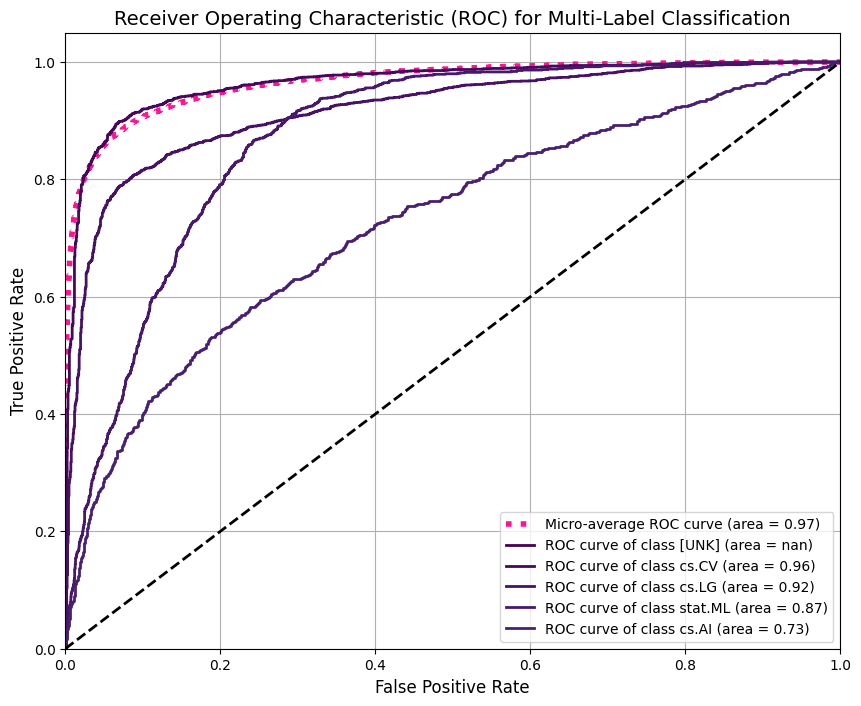

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_score
)

# --- 1. Get Predictions and True Labels ---
print("⚙️  Gathering predictions and true labels from the validation set...")

# Get the raw probability predictions from the model
y_pred_probs = model1.predict(validation_dataset)

# Extract the true multi-hot encoded labels from the dataset
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)

# To calculate metrics like F1 and recall, we need binary predictions.
# A common approach is to use a 0.5 threshold on the probabilities.
y_pred = (y_pred_probs > 0.5).astype(int)

print("✅ Done.\n")


# --- 2. Calculate Classification Metrics ---
print("📊  Calculating Classification Metrics...")

# Keras Binary Accuracy (measures the frequency of correct predictions per label)
_, binary_acc = model1.evaluate(validation_dataset, verbose=0)
print(f"Keras Binary Accuracy: {binary_acc:.4f}")

# Subset Accuracy (stricter: measures the frequency of samples where ALL labels are correct)
subset_acc = accuracy_score(y_true, y_pred)
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print("-" * 30)

# F1 Score (the harmonic mean of precision and recall)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score (Micro Avg): {f1_micro:.4f}")
print(f"F1 Score (Weighted Avg): {f1_weighted:.4f}")
print("-" * 30)


# Recall (the ability of the model to find all the relevant instances)
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
print(f"Recall (Micro Avg): {recall_micro:.4f}")
print(f"Recall (Weighted Avg): {recall_weighted:.4f}")
print("-" * 30)


# --- 3. Calculate AUC Score ---
# AUC is calculated on the prediction probabilities, not the binarized predictions.
print("📈  Calculating Area Under the Curve (AUC)...")

auc_micro = roc_auc_score(y_true, y_pred_probs, average='micro')
auc_weighted = roc_auc_score(y_true, y_pred_probs, average='weighted')
print(f"AUC Score (Micro Avg): {auc_micro:.4f}")
print(f"AUC Score (Weighted Avg): {auc_weighted:.4f}")
print("\n")


# --- 4. Plot ROC Curves ---
print("🎨  Generating ROC Curve plot...")

# Setup for plotting
plt.figure(figsize=(10, 8))

# Calculate the micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC curve (area = {auc_micro:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for a few individual classes as examples
n_classes = y_true.shape[1]
colors = plt.cm.get_cmap('viridis', n_classes)

# To avoid a cluttered plot, we'll only plot the first 5 classes
for i in range(min(5, n_classes)):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    class_auc = roc_auc_score(y_true[:, i], y_pred_probs[:, i])
    label = f'ROC curve of class {vocab[i]} (area = {class_auc:0.2f})'
    plt.plot(fpr, tpr, color=colors(i), lw=2, label=label)

# Final plot adjustments
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) for Multi-Label Classification', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [12]:
# --- Check the Word Vocabulary ---
word_vocab = text_vectorizer.get_vocabulary()
print(f"Total word vocabulary size: {len(word_vocab)}")
print("Sample of the 20 most frequent words:", word_vocab[:20])

Total word vocabulary size: 85130
Sample of the 20 most frequent words: ['[UNK]', np.str_('the'), np.str_('of'), np.str_('and'), np.str_('to'), np.str_('a'), np.str_('in'), np.str_('we'), np.str_('is'), np.str_('for'), np.str_('on'), np.str_('that'), np.str_('this'), np.str_('with'), np.str_('learning'), np.str_('as'), np.str_('of the'), np.str_('by'), np.str_('our'), np.str_('are')]


NameError: name 'vocabulary' is not defined

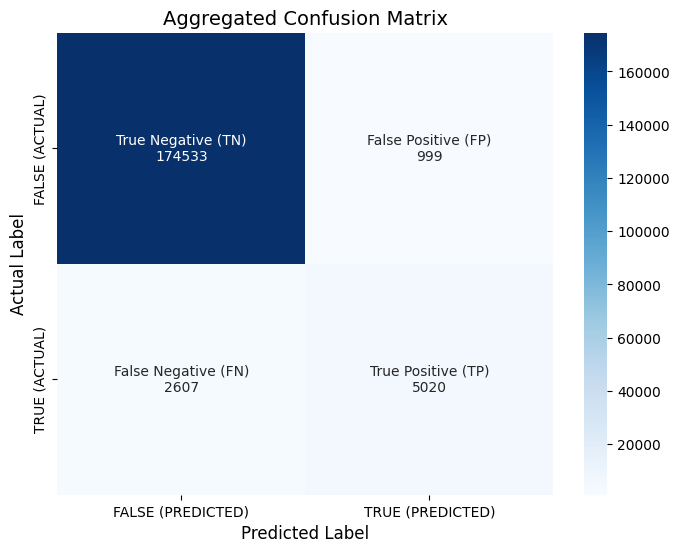

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# --- 1. Calculate Per-Label Confusion Matrices ---
# This creates a separate 2x2 confusion matrix for each class label.
# The format for each is [[TN, FP], [FN, TP]]
per_class_cm = multilabel_confusion_matrix(y_true, y_pred)

# --- 2. Aggregate the Results ---
# We sum the matrices along the first axis to get a total count of all
# True Negatives, False Positives, False Negatives, and True Positives.
aggregated_cm = per_class_cm.sum(axis=0)

# --- 3. Visualize the Matrix ---
plt.figure(figsize=(8, 6))

# Define the labels as you requested
labels = [['True Negative (TN)', 'False Positive (FP)'],
          ['False Negative (FN)', 'True Positive (TP)']]
counts = [[f"{value:d}" for value in row] for row in aggregated_cm]
annotations = [[f"{v1}\n{v2}" for v1, v2 in zip(l_row, c_row)]
               for l_row, c_row in zip(labels, counts)]


sns.heatmap(aggregated_cm, annot=annotations, fmt='', cmap='Blues',
            xticklabels=['FALSE (PREDICTED)', 'TRUE (PREDICTED)'],
            yticklabels=['FALSE (ACTUAL)', 'TRUE (ACTUAL)'])

plt.title('Aggregated Confusion Matrix', fontsize=14)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [11]:
import os
import pickle
import tensorflow as tf

# --- Create a directory to hold all the models ---
if not os.path.exists('models'):
    os.makedirs('models')

print("💾 Saving all necessary files to the 'models' directory...")

# --- Part 1: Save the Classification Components ---
# Save the main classification model (assumes it's in the 'model1' variable)
model1.save("models/model.keras")

# Save the text vectorizer (assumes it's in the 'text_vectorizer' variable)
vectorizer_model = tf.keras.Sequential([text_vectorizer])
vectorizer_model.compile()
vectorizer_model.save("models/vectorizer.h5")

# Save the label vocabulary (assumes it's in the 'vocab' variable)
with open("models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

# --- Part 2: Save the Info Retrieval Components ---
# This part assumes you have run the info retrieval cells and have these variables:
# 'combined_embeddings', 'titles', and the SentenceTransformer 'model'

# Save the combined embeddings and the list of titles
with open('models/embeddings.pkl', 'wb') as f:
    pickle.dump(combined_embeddings, f)
with open('models/sentences.pkl', 'wb') as f:
    pickle.dump(titles, f)

# Save the SentenceTransformer model using the recommended method
model.save('models/recommendation_model')

print("✅ All files saved successfully.")

# --- Part 3: Create a Zip File for Easy Downloading ---
print("\n📦 Zipping all files for download...")
!zip -r models.zip models

print("🎉 Zip file 'models.zip' created. It's ready for download!")

💾 Saving all necessary files to the 'models' directory...


✅ All files saved successfully.

📦 Zipping all files for download...
  adding: models/ (stored 0%)
  adding: models/model.keras (deflated 40%)
  adding: models/recommendation_model/ (stored 0%)
  adding: models/recommendation_model/tokenizer.json (deflated 71%)
  adding: models/recommendation_model/model.safetensors (deflated 9%)
  adding: models/recommendation_model/sentence_bert_config.json (deflated 9%)
  adding: models/recommendation_model/vocab.txt (deflated 53%)
  adding: models/recommendation_model/config.json (deflated 47%)
  adding: models/recommendation_model/README.md (deflated 64%)
  adding: models/recommendation_model/special_tokens_map.json (deflated 80%)
  adding: models/recommendation_model/tokenizer_config.json (deflated 73%)
  adding: models/recommendation_model/modules.json (deflated 62%)
  adding: models/recommendation_model/1_Pooling/ (stored 0%)
  adding: models/recommendation_model/1_Pooling/config.json (deflated 59%)
  adding: models/recommendation_model/2_Norma

### NEW INFO RETRIEVAL

In [7]:
import pandas as pd
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer

print("🚀 Starting Step 1: Creating the Weighted Embedding Library...")

# --- 1. Prepare the Data ---
# We no longer drop the 'summaries' column. We need both titles and summaries.
print("   - Preparing data... keeping both titles and summaries.")
# This assumes 'arxiv_data' is loaded and has 'titles' and 'summaries' columns.
# Let's create a clean copy to work with for this task.
rec_df = arxiv_data[['titles', 'summaries']].copy()
rec_df.drop_duplicates(inplace=True)
rec_df.reset_index(drop=True, inplace=True)

# Create separate lists for titles and summaries
titles = rec_df['titles'].tolist()
summaries = rec_df['summaries'].tolist()


# --- 2. Load the Sentence Transformer Model ---
print("   - Loading the pre-trained Sentence Transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')


# --- 3. Define the Weights ---
# The title is generally more important for the core topic.
# You can experiment with these values, but they must sum to 1.0.
title_weight = 0.7
summary_weight = 0.3
print(f"   - Using weights: Title={title_weight}, Summary={summary_weight}")


# --- 4. Create Separate Embeddings ---
# This will take some time as it processes both titles and summaries.
print("   - Encoding all titles... (this may take a moment)")
title_embeddings = model.encode(titles, show_progress_bar=True)

print("   - Encoding all summaries... (this will take longer)")
summary_embeddings = model.encode(summaries, show_progress_bar=True)


# --- 5. Calculate the Weighted Average ---
print("   - Calculating the combined weighted average embeddings...")
combined_embeddings = (title_weight * title_embeddings) + (summary_weight * summary_embeddings)


# --- 6. Save the Results ---
print("   - Saving the new library to files...")

# Save the powerful, combined embeddings
with open('combined_embeddings.pkl', 'wb') as f:
    pickle.dump(combined_embeddings, f)

# We still save the original titles to display as recommendations
with open('sentences.pkl', 'wb') as f:
    pickle.dump(titles, f)

print("\n✅ Step 1 complete. Your new, more powerful search library has been created and saved!")

🚀 Starting Step 1: Creating the Weighted Embedding Library...
   - Preparing data... keeping both titles and summaries.
   - Loading the pre-trained Sentence Transformer model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   - Using weights: Title=0.7, Summary=0.3
   - Encoding all titles... (this may take a moment)


Batches:   0%|          | 0/1218 [00:00<?, ?it/s]

   - Encoding all summaries... (this will take longer)


Batches:   0%|          | 0/1218 [00:00<?, ?it/s]

   - Calculating the combined weighted average embeddings...
   - Saving the new library to files...

✅ Step 1 complete. Your new, more powerful search library has been created and saved!


In [8]:
import pickle
import torch
import numpy as np
from sentence_transformers import SentenceTransformer, util

# --- Load all necessary files once ---
MODEL = SentenceTransformer('all-MiniLM-L6-v2')
with open('combined_embeddings.pkl', 'rb') as f:
    LIBRARY_EMBEDDINGS = pickle.load(f)
with open('sentences.pkl', 'rb') as f:
    LIBRARY_TITLES = pickle.load(f)


def get_recommendations(query_title, query_summary, top_k=5):
    """
    Takes a query title and summary, and returns the top_k most similar papers.
    """
    # 1. Create the weighted query embedding
    title_weight = 0.7
    summary_weight = 0.3
    query_title_emb = MODEL.encode(query_title)
    query_summary_emb = MODEL.encode(query_summary)
    query_embedding = (title_weight * query_title_emb) + (summary_weight * query_summary_emb)

    # 2. Calculate cosine similarity against the library
    cosine_scores = util.cos_sim(LIBRARY_EMBEDDINGS, query_embedding)

    # 3. Get the top k results
    top_results = torch.topk(cosine_scores, dim=0, k=top_k, sorted=True)

    # 4. Display the results
    print("\n" + "="*35)
    print(f"✅ Top {top_k} Recommended Papers:")
    print("="*35)
    for score, idx in zip(top_results.values, top_results.indices):
        print(f"- {LIBRARY_TITLES[idx.item()]} (Score: {score.item():.4f})")


# --- EXAMPLE USAGE ---
# Paper 1: Attention/Transformer
q_title_1 = "Attention Is All You Need"
q_summary_1 = "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks, including an encoder and a decoder..." # (Shortened for brevity)
get_recommendations(q_title_1, q_summary_1)

# Paper 2: BERT
q_title_2 = "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"
q_summary_2 = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers..." # (Shortened for brevity)
get_recommendations(q_title_2, q_summary_2)


✅ Top 5 Recommended Papers:
- Attention that does not Explain Away (Score: 0.7352)
- Agglomerative Attention (Score: 0.7147)
- Long Short-Term Attention (Score: 0.7138)
- Pay Attention when Required (Score: 0.6939)
- Bottom-up Attention, Models of (Score: 0.6921)

✅ Top 5 Recommended Papers:
- BEiT: BERT Pre-Training of Image Transformers (Score: 0.7226)
- VL-BERT: Pre-training of Generic Visual-Linguistic Representations (Score: 0.7106)
- Accelerating Training of Transformer-Based Language Models with Progressive Layer Dropping (Score: 0.7053)
- lamBERT: Language and Action Learning Using Multimodal BERT (Score: 0.6952)
- Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context (Score: 0.6875)


In [ ]:
def jaccard_similarity(set1, set2):
    """Calculates the Jaccard Similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    # Avoid division by zero
    if union == 0:
        return 1.0
    else:
        return intersection / union

# Example Usage:
query_labels = {'cs.LG', 'cs.AI'}
reco_labels = {'cs.LG', 'stat.ML'}

score = jaccard_similarity(set(query_labels), set(reco_labels))
print(f"Jaccard Similarity: {score:.4f}")
# Output: Jaccard Similarity: 0.3333

In [ ]:
import pickle
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from tqdm.auto import tqdm # For a nice progress bar
from sklearn.metrics import ndcg_score

# ==============================================================================
# 1. SETUP: Load all models, data, and create a lookup map
# ==============================================================================
print("🚀 Setting up the validation environment...")

# --- Load the recommendation system components ---
MODEL = SentenceTransformer('all-MiniLM-L6-v2')
with open('combined_embeddings.pkl', 'rb') as f:
    LIBRARY_EMBEDDINGS = pickle.load(f)
with open('sentences.pkl', 'rb') as f:
    LIBRARY_TITLES = pickle.load(f)

# --- Create a Title-to-Labels Dictionary for fast lookups ---
title_to_labels_map = {title: set(labels) for title, labels in zip(arxiv_data['titles'], arxiv_data['terms'])}
print("✅ Setup complete.")

# ==============================================================================
# 2. HELPER FUNCTIONS
# ==============================================================================

def jaccard_similarity(set1, set2):
    """Calculates the Jaccard Similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 1.0

def get_recommendation_titles(query_title, query_summary, top_k=5):
    """Gets the top_k recommended paper titles for a given query."""
    title_weight = 0.7
    summary_weight = 0.3
    query_title_emb = MODEL.encode(query_title)
    query_summary_emb = MODEL.encode(query_summary)
    query_embedding = (title_weight * query_title_emb) + (summary_weight * query_summary_emb)

    cosine_scores = util.cos_sim(LIBRARY_EMBEDDINGS, query_embedding)
    top_results = torch.topk(cosine_scores, dim=0, k=top_k, sorted=True)

    return [LIBRARY_TITLES[idx.item()] for idx in top_results.indices]

# ==============================================================================
# 3. MAIN VALIDATION LOOP
# ==============================================================================
print("\n🔍 Starting validation on the test set with multiple metrics...")

all_precisions = []
all_reciprocal_ranks = []
all_ndcgs = []
K = 5

for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Validating"):
    query_title = row['titles']
    query_summary = row['summaries']
    true_query_labels = set(row['terms'])

    if not true_query_labels:
        continue

    recommended_titles = get_recommendation_titles(query_title, query_summary, top_k=K)

    # --- Calculate relevance (Jaccard score) for each recommendation ---
    relevance_scores = []
    for reco_title in recommended_titles:
        reco_labels = title_to_labels_map.get(reco_title, set())
        if reco_labels:
            score = jaccard_similarity(true_query_labels, reco_labels)
            relevance_scores.append(score)
        else:
            relevance_scores.append(0) # Append 0 if labels aren't found

    if not relevance_scores:
        continue

    # --- Calculate metrics for this query ---

    # 🎯 Precision@K
    relevant_items_count = sum([1 for score in relevance_scores if score > 0])
    precision_at_k = relevant_items_count / K
    all_precisions.append(precision_at_k)

    # 🥇 Reciprocal Rank
    reciprocal_rank = 0
    for i, score in enumerate(relevance_scores):
        if score > 0:
            reciprocal_rank = 1 / (i + 1)
            break # Stop after finding the first relevant item
    all_reciprocal_ranks.append(reciprocal_rank)

    # 🏆 nDCG@K
    # The relevance scores are our "true" scores. We compare this list to itself
    # to get the nDCG for this specific ranking.
    true_relevance = np.asarray([relevance_scores])
    ndcg_at_k = ndcg_score(true_relevance, true_relevance, k=K)
    all_ndcgs.append(ndcg_at_k)

# ==============================================================================
# 4. FINAL RESULTS
# ==============================================================================

# Calculate the final average score across the entire test set
mean_precision_at_5 = np.mean(all_precisions)
mean_reciprocal_rank = np.mean(all_reciprocal_ranks)
mean_ndcg_at_5 = np.mean(all_ndcgs)

print("\n" + "="*45)
print("🎉 QUANTITATIVE VALIDATION COMPLETE 🎉")
print("="*45)
print(f"🎯 Mean Precision@5: {mean_precision_at_5:.4f}")
print(f"🥇 Mean Reciprocal Rank (MRR): {mean_reciprocal_rank:.4f}")
print(f"🏆 Mean nDCG@5: {mean_ndcg_at_5:.4f}")

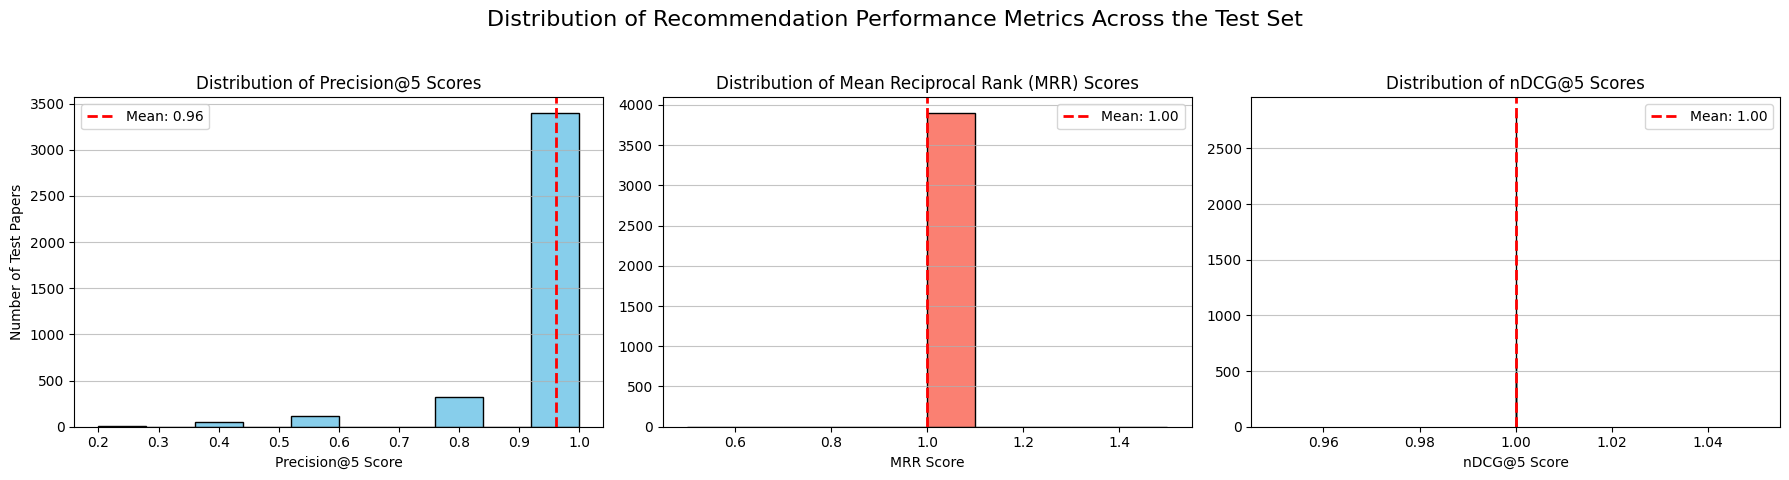

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 3 subplots, arranged in a single row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Recommendation Performance Metrics Across the Test Set', fontsize=16)

# --- 1. Histogram for Precision@5 ---
ax1 = axes[0]
ax1.hist(all_precisions, bins=10, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Precision@5 Scores', fontsize=12)
ax1.set_xlabel('Precision@5 Score')
ax1.set_ylabel('Number of Test Papers')
# Add a vertical line for the mean score
ax1.axvline(np.mean(all_precisions), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_precisions):.2f}')
ax1.legend()
ax1.grid(axis='y', alpha=0.75)


# --- 2. Histogram for MRR ---
ax2 = axes[1]
ax2.hist(all_reciprocal_ranks, bins=10, color='salmon', edgecolor='black')
ax2.set_title('Distribution of Mean Reciprocal Rank (MRR) Scores', fontsize=12)
ax2.set_xlabel('MRR Score')
# ax2.set_ylabel('Number of Test Papers') # Optional: can remove for clarity
# Add a vertical line for the mean score
ax2.axvline(np.mean(all_reciprocal_ranks), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_reciprocal_ranks):.2f}')
ax2.legend()
ax2.grid(axis='y', alpha=0.75)


# --- 3. Histogram for nDCG@5 ---
ax3 = axes[2]
ax3.hist(all_ndcgs, bins=10, color='lightgreen', edgecolor='black')
ax3.set_title('Distribution of nDCG@5 Scores', fontsize=12)
ax3.set_xlabel('nDCG@5 Score')
# ax3.set_ylabel('Number of Test Papers') # Optional: can remove for clarity
# Add a vertical line for the mean score
ax3.axvline(np.mean(all_ndcgs), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_ndcgs):.2f}')
ax3.legend()
ax3.grid(axis='y', alpha=0.75)


# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.savefig('recommendation_performance_charts.png')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import pickle
import os
import re
from ast import literal_eval

print("🚀 Starting script to create all model files...")

# ==============================================================================
# 0. SETUP
# ==============================================================================
# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
    print("Created 'models' directory.")

# Load the dataset
print("Loading arxiv_data.csv...")
try:
    arxiv_data = pd.read_csv("arxiv_data.csv")
except FileNotFoundError:
    print("\nERROR: 'arxiv_data.csv' not found. Please place it in the same folder as this script.")
    exit()

# ==============================================================================
# 1. GENERATE CLASSIFICATION MODEL FILES
# ==============================================================================
print("\n--- Part 1: Training and Saving the Classification Model ---")

# --- 1.1 Preprocessing (Streamlined Version) ---
print("Step 1.1: Preprocessing data...")
arxiv_data = arxiv_data.drop_duplicates(subset=['titles'])

def clean_and_normalize_terms(term_string):
    try:
        terms = literal_eval(term_string)
    except (ValueError, SyntaxError):
        terms = term_string
    if isinstance(terms, list):
        return [str(term).strip() for term in terms]
    elif isinstance(terms, str):
        return [term.strip() for term in re.split('[,;]', terms)]
    else:
        return []

arxiv_data['terms'] = arxiv_data['terms'].apply(clean_and_normalize_terms)

train_df, test_val_df = train_test_split(arxiv_data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

class_distribution = train_df['terms'].explode().value_counts()
min_samples =
classes_to_keep = class_distribution[class_distribution >= min_samples].index.tolist()

def filter_terms_list(terms_list):
    return [term for term in terms_list if term in classes_to_keep]

train_df['terms'] = train_df['terms'].apply(filter_terms_list)
train_df = train_df[train_df['terms'].str.len() > 0]

# --- 1.2 Create and Adapt Vectorizers/Lookups ---
print("Step 1.2: Creating vocab and text vectorizer...")
# Create label lookup
terms = tf.ragged.constant(train_df['terms'].values)
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

# Create text vectorizer
vocabulary_size = len(train_df["summaries"].str.lower().str.split().apply(set).explode().unique())
text_vectorizer = TextVectorization(max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf")
text_vectorizer.adapt(train_df['summaries'])

# --- 1.3 Train the Model ---
print("Step 1.3: Training the classification model...")
def make_dataset(dataframe):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["summaries"].values, label_binarized))
    return dataset.batch(128).map(lambda text, label: (text_vectorizer(text), label)).prefetch(tf.data.AUTOTUNE)

train_dataset = make_dataset(train_df)

model1 = keras.Sequential([
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])
model1.fit(train_dataset, epochs=7) # Training for 7 epochs as a good baseline

# --- 1.4 Save All Classification Files ---
print("Step 1.4: Saving all classification files to 'models/' directory...")
# Save the main model
model1.save("models/model.h5")
# Save the text vectorizer config
with open("models/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(text_vectorizer.get_config(), f)
# CRITICAL: Save the text vectorizer weights
with open("models/text_vectorizer_weights.pkl", "wb") as f:
    pickle.dump(text_vectorizer.get_weights(), f)
# Save the label vocabulary
with open("models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

# ==============================================================================
# 2. GENERATE RECOMMENDATION MODEL FILES
# ==============================================================================
print("\n--- Part 2: Creating and Saving the Recommendation System Files ---")
# Note: This creates the files for the original, title-only recommender
# because that is what your current app.py script expects.

# --- 2.1 Prepare Data and Model ---
print("Step 2.1: Loading Sentence Transformer model...")
rec_model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = arxiv_data['titles'].drop_duplicates().tolist()

# --- 2.2 Create Embeddings ---
print("Step 2.2: Encoding titles for the recommendation library... (this may take a while)")
embeddings = rec_model.encode(sentences, show_progress_bar=True)

# --- 2.3 Save All Recommendation Files ---
print("Step 2.3: Saving all recommendation files to 'models/' directory...")
with open('models/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)
with open('models/sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)
with open('models/rec_model.pkl', 'wb') as f:
    pickle.dump(rec_model, f)


print("\n✅ All files have been created successfully in the 'models' directory!")

🚀 Starting script to create all model files...
Created 'models' directory.
Loading arxiv_data.csv...

--- Part 1: Training and Saving the Classification Model ---
Step 1.1: Preprocessing data...
Step 1.2: Creating vocab and text vectorizer...
Step 1.3: Training the classification model...
Epoch 1/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - binary_accuracy: 0.9410 - loss: 0.1707
Epoch 2/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 42s 172ms/step - binary_accuracy: 0.9812 - loss: 0.0640
Epoch 3/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - binary_accuracy: 0.9847 - loss: 0.0499
Epoch 4/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - binary_accuracy: 0.9868 - loss: 0.0422
Epoch 5/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - binary_accuracy: 0.9885 - loss: 0.0367
Epoch 6/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 42s 172ms/step - binary_accuracy: 0.9896 - loss: 0.0332
Epoch 7/7
244/244 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - binary_accuracy: 0.9909 - loss: 0.0289


Step 1.4: Saving all classification files to 'models/' directory...

--- Part 2: Creating and Saving the Recommendation System Files ---
Step 2.1: Loading Sentence Transformer model...
Step 2.2: Encoding titles for the recommendation library... (this may take a while)


Batches:   0%|          | 0/1218 [00:00<?, ?it/s]

Step 2.3: Saving all recommendation files to 'models/' directory...

✅ All files have been created successfully in the 'models' directory!


In [ ]:
# --- 2.3 Save All Recommendation Files (Corrected Version) ---
print("Step 2.3: Saving all recommendation files to 'models/' directory...")
with open('models/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)
with open('models/sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)

# This is the corrected part: Use the model's own save method
# It will create a new folder named 'recommendation_model' inside 'models/'
rec_model.save('models/recommendation_model')

Step 2.3: Saving all recommendation files to 'models/' directory...


In [ ]:
!zip -r models.zip models

  adding: models/ (stored 0%)
  adding: models/model.h5 (deflated 40%)
  adding: models/recommendation_model/ (stored 0%)
  adding: models/recommendation_model/tokenizer.json (deflated 71%)
  adding: models/recommendation_model/model.safetensors (deflated 9%)
  adding: models/recommendation_model/sentence_bert_config.json (deflated 9%)
  adding: models/recommendation_model/vocab.txt (deflated 53%)
  adding: models/recommendation_model/config.json (deflated 47%)
  adding: models/recommendation_model/README.md (deflated 64%)
  adding: models/recommendation_model/special_tokens_map.json (deflated 80%)
  adding: models/recommendation_model/tokenizer_config.json (deflated 73%)
  adding: models/recommendation_model/modules.json (deflated 62%)
  adding: models/recommendation_model/1_Pooling/ (stored 0%)
  adding: models/recommendation_model/1_Pooling/config.json (deflated 59%)
  adding: models/recommendation_model/2_Normalize/ (stored 0%)
  adding: models/recommendation_model/config_sentence_

In [ ]:
!zip -r recommendation_model.zip models/recommendation_model

  adding: models/recommendation_model/ (stored 0%)
  adding: models/recommendation_model/tokenizer.json (deflated 71%)
  adding: models/recommendation_model/model.safetensors (deflated 9%)
  adding: models/recommendation_model/sentence_bert_config.json (deflated 9%)
  adding: models/recommendation_model/vocab.txt (deflated 53%)
  adding: models/recommendation_model/config.json (deflated 47%)
  adding: models/recommendation_model/README.md (deflated 64%)
  adding: models/recommendation_model/special_tokens_map.json (deflated 80%)
  adding: models/recommendation_model/tokenizer_config.json (deflated 73%)
  adding: models/recommendation_model/modules.json (deflated 62%)
  adding: models/recommendation_model/1_Pooling/ (stored 0%)
  adding: models/recommendation_model/1_Pooling/config.json (deflated 59%)
  adding: models/recommendation_model/2_Normalize/ (stored 0%)
  adding: models/recommendation_model/config_sentence_transformers.json (deflated 41%)


In [13]:
!pip list


Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
absolufy-imports                      0.3.1
accelerate                            1.10.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
alembic                               1.16.5
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.8.1
arrow 